In [1]:
import os, sys
import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

import pickle

import numpy as np

# Import pytorch dependencies
import torch
from torch.utils.data import DataLoader

# Import toolkits
from utils.visualization_3D_objects import *

from nn.pointnetae import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Hyper Parameters

In [2]:
DATASET = 'shapenet'
CATEGORY = 'car'
DATA_PATH = os.path.join(HOME_PATH, "data/preprocessed", DATASET, CATEGORY)
CHECKPOINT_FOLDER = os.path.join(HOME_PATH, "saved_nn")
MODEL_TYPE = "PointNetAE_car"

### Examine Results

In [3]:
#load all preprocessed data
f1 = open(os.path.join(DATA_PATH,'train.txt'),'rb')
X_train = pickle.load(f1)
f2 = open(os.path.join(DATA_PATH,'test.txt'),'rb')
X_test = pickle.load(f2)

In [4]:
BATCH_SIZE = 16

# construct dataloader
train_loader = DataLoader(
    X_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)
val_loader = DataLoader(
    X_test, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)
full_loader = DataLoader(
    np.vstack([X_train, X_test]), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    drop_last=True
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
    
model_test = PointNet_AE(3, 2048)
state_dict = torch.load(os.path.join(CHECKPOINT_FOLDER, MODEL_TYPE + '.pth')) # change the path to your own checkpoint file
model_test.cuda()
model_test.load_state_dict(state_dict['state_dict'])
model_test.eval()

print(state_dict['epoch'])

Run on GPU...
184


In [6]:
x = val_loader.__iter__().next() # hack to grab a batch

inputs = x.float().to(device)

outputs, _ = model_test(inputs)

# X = inputs.cpu().detach().numpy()[0]
# X_hat = outputs.cpu().detach().numpy()[0]

# fig1 = draw3DPoints(X, point_size = 5, title = "Original "+ CATEGORY, show = True)
# save3DPointsImage(fig1, save_path = os.path.join(HOME_PATH, "images"), title = "original_car")
# fig2 = draw3DPoints(X_hat, point_size = 5, title = "Reconstructed "+ CATEGORY, show = True)
# save3DPointsImage(fig2, save_path = os.path.join(HOME_PATH, "images"), title = "reconstructed_car")

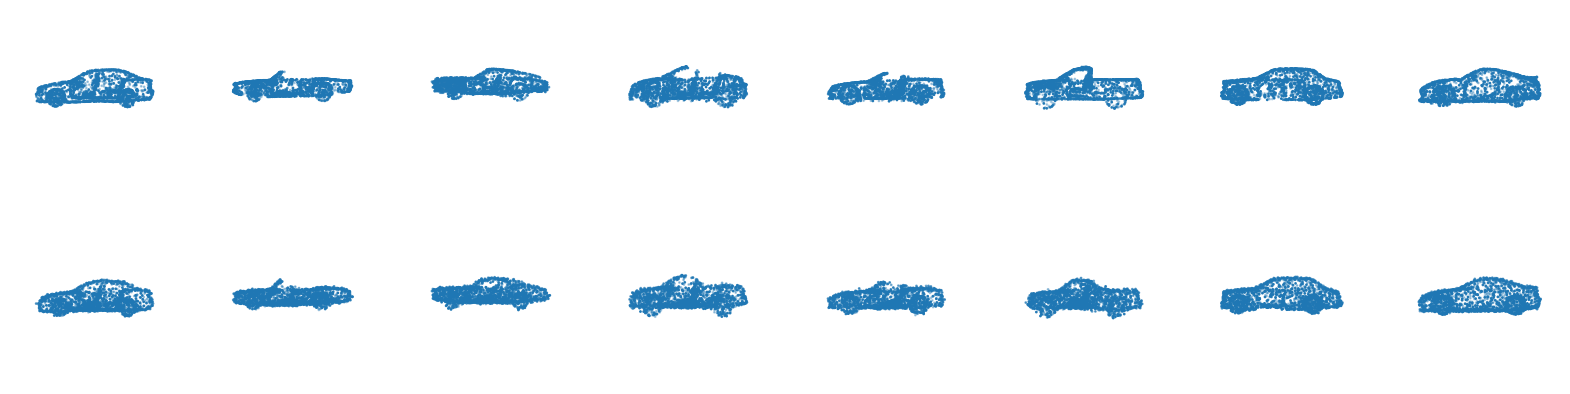

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plt.figure(figsize=(20,5))

# Get the test data

# Plot the data
for i in range(8):
    X = inputs.cpu().detach().numpy()[i]
    x, y, z = X[0], X[1], X[2]
    ax = fig.add_subplot(2, 8, i + 1, projection='3d')
    ax.scatter(x, y, z, s = 1)
    ax.view_init(-90, 90)

    l_bound = np.min(x)+1; u_bound = np.max(x)-1
    # l_bound = -5; u_bound = 5
    ax.set_xlim(l_bound, u_bound)
    ax.set_ylim(l_bound, u_bound)
    ax.set_zlim(l_bound, u_bound)
    ax.axis('off')

for i in range(8):
    X = outputs.cpu().detach().numpy()[i]
    x, y, z = X[0], X[1], X[2]
    ax = fig.add_subplot(2, 8, 8 + i + 1, projection='3d')
    ax.scatter(x, y, z, s = 1)
    ax.view_init(-90, 90)

    l_bound = np.min(x)+1; u_bound = np.max(x)-1
    # l_bound = -5; u_bound = 5
    ax.set_xlim(l_bound, u_bound)
    ax.set_ylim(l_bound, u_bound)
    ax.set_zlim(l_bound, u_bound)
    ax.axis('off')

plt.show()
# plt.savefig(os.path.join(HOME_PATH, "images","comparing_ground_truth.png"))

In [ ]:
def extractGlobalFeatForAllData(full_loader, model_test, device):
    global_feat_lst = []
    for batch_idx, (inputs) in enumerate(full_loader):
        # copy inputs to device
        inputs = inputs.float().to(device)
        # compute the output and loss
        outputs, global_feat_i = model_test(inputs)
        global_feat_lst.append(global_feat_i.cpu().detach().numpy())
        
    global_feat = np.vstack(global_feat_lst)
    return global_feat

global_feat = extractGlobalFeatForAllData(full_loader, model_test, device)
np.savetxt("global_feat.csv", global_feat, delimiter=",")